# Addition Interpretability Analysis

This CoLab unerpins the [Addition Interpretability Cohort3 - OverLeaf](https://www.overleaf.com/project/64c75f5e7211fe5cb86623d2) paper. It builds on Neel Nanda's work on the 5 Digit Addition neural net model, to elucidate the internal algorithm.


This workbook includes content from:

* [A Mechanistic Interpretability Analysis of Grokking (Stable)](https://colab.research.google.com/drive/1F6_1_cWXE5M7WocUcpQWp3v8z4b1jL20#scrollTo=XdjjunLxwi_b)

* [Non_Modular_Addition_Grokking_Tasks.ipynb](https://github.com/mechanistic-interpretability-grokking/progress-measures-paper/blob/main/Non_Modular_Addition_Grokking_Tasks%20(1).ipynb)

* [Grokking_Demo.ipynb](https://github.com/neelnanda-io/TransformerLens/blob/main/demos/Grokking_Demo.ipynb)

I'm very grateful to the people who created those resources.



## Setup

Mainly from https://github.com/neelnanda-io/TransformerLens/blob/main/demos/Grokking_Demo.ipynb


In [1]:
# Janky code to do different setup when run in a Colab notebook vs VSCode
DEVELOPMENT_MODE = True
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
    %pip install git+https://github.com/neelnanda-io/TransformerLens.git@new-demo
    %pip install git+https://github.com/callummcdougall/CircuitsVis.git#subdirectory=python
    #%pip install circuitsvis
    %pip install jaxtyping

    # PySvelte is an unmaintained visualization library, use it as a backup if circuitsvis isn't working
    # # Install another version of node that makes PySvelte work way faster
    # !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
    # %pip install git+https://github.com/neelnanda-io/PySvelte.git
except:
    IN_COLAB = False
    print("Running as a Jupyter notebook - intended for development only!")
    from IPython import get_ipython

    ipython = get_ipython()
    # Code to automatically update the HookedTransformer code as its edited without restarting the kernel
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")

Running as a Colab notebook
  Cloning https://github.com/neelnanda-io/TransformerLens.git (to revision new-demo) to /tmp/pip-req-build-0pjb8nnk
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/TransformerLens.git /tmp/pip-req-build-0pjb8nnk
  Running command git checkout -b new-demo --track origin/new-demo
  Switched to a new branch 'new-demo'
  Branch 'new-demo' set up to track remote branch 'new-demo' from 'origin'.
  Resolved https://github.com/neelnanda-io/TransformerLens.git to commit 25879ea6d969e8e9c962957bc945be42de522b4a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached torch-1.13.1-cp310-cp310-manylinux1_x86_64.whl (887.5 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1
    Uninstalling torch-2.0.1:
      Successfully uninstalled torch-2.0.1
ERROR: pip's dependency resolver does not currently take into account 

In [2]:
# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio
if IN_COLAB or not DEVELOPMENT_MODE:
    pio.renderers.default = "colab"
else:
    pio.renderers.default = "notebook_connected"
print(f"Using renderer: {pio.renderers.default}")

Using renderer: colab


In [3]:
pio.templates['plotly'].layout.xaxis.title.font.size = 20
pio.templates['plotly'].layout.yaxis.title.font.size = 20
pio.templates['plotly'].layout.title.font.size = 30

In [4]:
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.auto as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from torchtyping import TensorType as TT
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML
from IPython.display import display

import circuitsvis as cv
import plotly.graph_objects as go


In [5]:
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

In [6]:
def imshow(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def line(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.line(utils.to_numpy(tensor), labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

## Addition Interpretability - Configuration

From https://colab.research.google.com/drive/1aA7ZuBvvKf5lDpeFEtQO_s1tFGsIRVJG#scrollTo=Ya5wc5CnKplj

In [7]:
# where we save the model
PTH_LOCATION = "model.pth"


In [8]:
# Train or load model? Training saves the model weights in CoLab files
train_model = True #@param

# Optional. Performs sanity checks on 1% of the data
unit_tests = True #@param

In [9]:
#@markdown Model
n_layers = 1
d_vocab = 12
d_model = 512 #@param
n_heads = 4
d_head = d_model//n_heads
d_mlp = 4 * d_model
seed = 129000 #@param
#@markdown Data
n_digits = 5 #@param
n_ctx = 3*n_digits + 3
act_fn = 'relu'
batch_size = 64 #@param
#@markdown Optimizer
lr = 0.00008 # 1e-4 #@param
weight_decay = 0.1 #@param
n_epochs = 5000 #@param

PLUS_INDEX = 10
EQUALS_INDEX = 11

In [10]:
# Embedding / Unembedding

def tokens_to_string(tokens):
    tokens = utils.to_numpy(tokens)
    x = "".join([str(i) for i in tokens[:5]])
    y = "".join([str(i) for i in tokens[6:11]])
    z = "".join([str(i) for i in tokens[12:]])
    return f"  {x} + {y} = {z}"

def string_to_tokens(string, batch=False):
    lookup = {str(i):i for i in range(10)}
    lookup['+']=10
    lookup['=']=11
    tokens = [lookup[i] for i in string if i not in '\n ']
    if batch:
        return torch.tensor(tokens)[None, :]
    else:
        return torch.tensor(tokens)

In [11]:
# Transformer creation

# Refer https://neelnanda-io.github.io/TransformerLens/transformer_lens.html#transformer_lens.HookedTransformerConfig.HookedTransformerConfig
cfg = HookedTransformerConfig(
    n_layers = n_layers,
    n_heads = n_heads,
    d_model = d_model,
    d_head = d_head,
    d_mlp = d_mlp,
    act_fn = act_fn,
    normalization_type = 'LN',
    d_vocab=d_vocab,
    d_vocab_out=d_vocab,
    n_ctx=n_ctx,
    init_weights = True,
    device="cuda",
    seed = seed,
)

model = HookedTransformer(cfg)

optimizer = optim.AdamW(model.parameters(),
                        lr=lr,
                        weight_decay=weight_decay,
                        betas=(0.9, 0.98))

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda step: min(step/10, 1))

# Addition Interpretability - Set Up
Data generator (expanded and with unit test), paper sub-task calculations.

In [12]:
# Loss functions

# Calculate the per-token probability by comparing a batch of prediction "logits" to answer "tokens"
def logits_to_tokens_loss(logits, tokens):

    # last "digit" columns of the input tokens are the addition prediction.
    # A 5 digit addition problem can give a 6 digit answer
    trunc_logits = logits[:, -(n_digits+2):-1]

    # Convert raw score (logits) vector into a probability distribution.
    # Emphasize the largest scores and suppress the smaller ones, to make them more distinguishable.
    log_probs = F.log_softmax(trunc_logits.to(torch.float64), dim=-1)

    # last "digit" columns of the input tokens are the addition "correct" answer.
    ans_tokens = tokens[:, -(n_digits+1):]

    # Extract values from the log_probs tensor, based on indices from the ans_tokens tensor
    pred_log_probs = torch.gather(log_probs, -1, ans_tokens[:, :, None])[..., 0]

    return pred_log_probs

# Calculate loss as negative of average per-token mean probability
def loss_fn(pred_log_probs):
   return -pred_log_probs.mean(0)

In [13]:
# Define "iterator" data generator function. Invoke using next().
# Batch entries are in format XXXXX+YYYYY=ZZZZZZ e.g. 55003+80002=135005
# Returns characteristics of each batch entry to aid later graphing
def data_generator(batch_size, n_digits, seed):
    torch.manual_seed(seed)
    while True:
        #generate a batch of addition questions (answers calculated below)
        batch = torch.zeros((batch_size, 3*n_digits+3)).to(torch.int64)
        x = torch.randint(0, 10, (batch_size, n_digits))
        y = torch.randint(0, 10, (batch_size, n_digits))
        batch[:, :n_digits] = x
        batch[:, n_digits] = PLUS_INDEX
        batch[:, 1+n_digits:1+n_digits*2] = y
        batch[:, 1+n_digits*2] = EQUALS_INDEX
        #print("Batch", batch)

        # These attributes are used for testing the model training progress
        base_adds = torch.zeros((batch_size,n_digits)).to(torch.int64)
        make_carry1s = torch.zeros((batch_size,n_digits)).to(torch.int64)
        sum9s = torch.zeros((batch_size,n_digits)).to(torch.int64)
        use_carry1s = torch.zeros((batch_size,n_digits)).to(torch.int64)
        use_sum9s = torch.zeros((batch_size,n_digits)).to(torch.int64)

        # generate the addition question answers & other info for testing
        for i in range(n_digits):
            # the column in the test attribtues being updated
            test_col = n_digits-1-i

            base_add = batch[:, n_digits-1-i]+batch[:, 2*n_digits-i]
            base_adds[:, test_col] = base_add

            sum9 = (base_add == 9)
            sum9s[:, test_col] = sum9

            if i>0:
              use_carry1s[:, test_col] = make_carry1s[:, test_col+1]
            use_carry = use_carry1s[:, test_col]

            use_sum9s[:, test_col] = sum9 & use_carry;

            digit_sum = base_add + use_carry1s[:, test_col]

            make_carry = (digit_sum >= 10)
            make_carry1s[:, test_col] = make_carry

            batch[:, -1-i] = (digit_sum % 10)

        # Final (possible) carry to highest digit of the sum
        batch[:, -1-n_digits] = make_carry1s[:, 0]

        yield batch.cuda(), base_adds.cuda(), make_carry1s.cuda(), sum9s.cuda(), use_carry1s.cuda(), use_sum9s.cuda()

In [14]:
# Data generator unit test (optional)
# This unit test checks that the above data_generator function is sensible
def unit_test_data_generator(train_tokens, train_use_carry1s, train_make_carry1s):
  test_token = train_tokens[0]
  test_use_carry = train_use_carry1s[0]
  test_make_carry = train_make_carry1s[0]

  if n_digits == 5:
    digits = test_token.cpu().numpy()
    use = test_use_carry.cpu().numpy()
    force = test_make_carry.cpu().numpy()
    num1 = digits[0]*10000 + digits[1]*1000 + digits[2]*100 + digits[3]*10 + digits[4];
    num2 = digits[6]*10000 + digits[7]*1000 + digits[8]*100 + digits[9]*10 + digits[10];
    sum = digits[12]*100000 + digits[13]*10000 + digits[14]*1000 + digits[15]*100 + digits[16]*10 + digits[17];
    assert num1 + num2 == sum, "Unit test failed: Data generator: Bad sum"
    assert (digits[4]+digits[10]+use[4]>=10) == force[4], "Unit test failed: Data generator: Bad carry 0"
    assert (digits[3]+digits[9]+use[3]>=10) == force[3], "Unit test failed: Data generator: Bad carry 1"
    assert (digits[2]+digits[8]+use[2]>=10) == force[2], "Unit test failed: Data generator: Bad carry 2"
    assert (digits[1]+digits[7]+use[1]>=10) == force[1], "Unit test failed: Data generator: Bad carry 3"
    assert (digits[0]+digits[6]+use[0]>=10) == force[0], "Unit test failed: Data generator: Bad carry 4"

In [15]:
# BaseAdd-only loss
# Identify the subset of (simple) tokens that only require BaseAdd (not UseCarry1 or UseSum9) to get the correct answer
# Array index 0 is the 'Units' digit. Array index 3 is the 'Thousands' digit.
ba_alldigits_loss = []
ba_alldigits_oneloss = 0

ba_perdigit_loss = []
ba_perdigit_cases = 0
ba_total_cases = 0


# BaseAdd AllDigits
# Identity the tokens in the batch where UseCarry1 is false for all columns simultaneously, so only BaseAdd is required on all digits
def calculate_baseadd_oneloss(tokens, per_token_losses, base_adds, use_carry1s):
  global ba_alldigits_oneloss

  answer = 0
  any_use_carry1s = torch.any(use_carry1s.bool(), dim=1)
  no_use_carry1s = ~ any_use_carry1s
  num_cases = utils.to_numpy(torch.sum(no_use_carry1s))
  if num_cases > 0 :
    filtered_loss = per_token_losses[:, -n_digits:] * no_use_carry1s[:, None]
    sum_loss = torch.sum(filtered_loss)
    answer = - utils.to_numpy(sum_loss) / num_cases
    answer = answer / n_digits  # Approximately align the scale of ba_alldigits_loss to ba_perdigit_loss
  ba_alldigits_oneloss = answer


def calculate_baseadd_loss(tokens, per_token_losses, base_adds, use_carry1s):
  global ba_perdigit_cases
  global ba_total_cases

  # BaseAdd AllDigits
  # Identity the tokens in the batch where UseCarry1 is false for all columns simultaneously, so only BaseAdd is required on all digits
  calculate_baseadd_oneloss(tokens, per_token_losses, base_adds, use_carry1s)
  ba_alldigits_loss.append(ba_alldigits_oneloss)


  # BaseAdd PerDigit
  # For each token in the batch, identity the digit columns (e.g. 3) where use_carry is false, so only BaseAdd is required on that digit
  ba_perdigit_cases = 0;
  for digit_num in range(n_digits):
    answer = 0
    no_use_carry = 1 - use_carry1s[:, -1-digit_num]
    num_cases = utils.to_numpy(torch.sum(no_use_carry))
    ba_perdigit_cases += num_cases
    ba_total_cases += num_cases
    if num_cases > 0 :
      filtered_loss = per_token_losses[:, -1-digit_num] * no_use_carry
      sum_loss = torch.sum(filtered_loss)
      answer = - utils.to_numpy(sum_loss) / num_cases
    if len(ba_perdigit_loss)<=digit_num:
      ba_perdigit_loss.append([])
    if (num_cases == 0) & (len(ba_perdigit_loss[digit_num]) > 0) :
      answer = ba_perdigit_loss[digit_num][-1] # Use the previous step's loss. Improves graph
    ba_perdigit_loss[digit_num].append(answer)

In [16]:
# UseCarry1 loss
# Identify the subset of tokens that require UseCarry1 (but not UseSum9) to get the correct answer
# Array index 0 is the 'Units' digit. Array index 3 is the 'Thousands' digit.
uc1_anydigits_loss = []
uc1_anydigits_oneloss = 0

uc1_perdigit_loss = []
uc1_perdigit_cases = 0
uc1_total_cases = 0


# UseCarry1 AnyDigits (exclude Sum9)
# Identity the tokens in the batch where UseCarry1 is used at least once over the columns & Sum9 is never used
def calculate_usecarry1_loss_any(tokens, per_token_losses, use_carry1s, sum9s):
  global uc1_anydigits_oneloss

  num_use_carry1s = torch.sum(use_carry1s, dim=1)
  any_use_carry1s = torch.where( num_use_carry1s != 0, 1, 0 ) # At least one digit uses UseCarry1
  num_sum9s = torch.sum(use_sum9s, dim=1)
  no_sum9s = torch.where( num_sum9s == 0, 1, 0 ) # No digits have Sum9 true
  filtered_cases = any_use_carry1s & no_sum9s
  num_cases = utils.to_numpy(torch.sum(filtered_cases))
  filtered_indices = torch.nonzero(filtered_cases).squeeze()
  filtered_token_losses = per_token_losses[filtered_indices]
  answer = - filtered_token_losses.mean()
  uc1_anydigits_oneloss = utils.to_numpy(answer)


def calculate_usecarry1_loss(tokens, per_token_losses, use_carry1s, sum9s):
  global uc1_perdigit_cases
  global uc1_total_cases

  # UseCarry1 AnyDigits (exclude Sum9)
  # Identity the tokens in the batch where UseCarry1 is used at least once over the columns & Sum9 is never used
  calculate_usecarry1_loss_any(tokens, per_token_losses, use_carry1s, sum9s)
  uc1_anydigits_loss.append(uc1_anydigits_oneloss)

  # UseCarry1 PerDigit (exclude Sum9)
  # For each token in the batch, identity the digit columns (e.g. 3) where UseCarry1 is used on the columns & Sum9 is not true
  uc1_perdigit_cases = 0
  for digit_num in range(n_digits):
    answer = 0
    use_carry = use_carry1s[:, -1-digit_num]
    no_sum9 = 1 - sum9s[:, -1-digit_num]
    filtered_cases = use_carry & no_sum9
    num_cases = utils.to_numpy(torch.sum(filtered_cases))
    uc1_perdigit_cases += num_cases
    uc1_total_cases += num_cases
    if num_cases > 0 :
      filtered_loss = per_token_losses[:, -1-digit_num] * filtered_cases
      sum_loss = torch.sum(filtered_loss)
      answer = - utils.to_numpy(sum_loss) / num_cases
    if len(uc1_perdigit_loss)<=digit_num:
      uc1_perdigit_loss.append([])
    if (num_cases==0) & (len(uc1_perdigit_loss[digit_num]) > 0) :
      answer = uc1_perdigit_loss[digit_num][-1] # Use the previous step's loss. Improves graph
    uc1_perdigit_loss[digit_num].append(answer)

In [17]:
# UseSum9 loss
# Identify the subset of tokens that require UseSum9 (being Sum9 and Carry1 from prev column) to get the correct answer
# Array index 0 is the 'Units' digit. Array index 3 is the 'Thousands' digit.
us9_anydigits_loss = []
us9_anydigits_oneloss = 0

us9_perdigit_loss = []
us9_perdigit_cases = 0
us9_total_cases = 0


# UseSum9 OneDigit
# Identity the tokens in the batch where UseSum9 is used at least once over the columns
def calculate_usesum9_oneloss(tokens, per_token_losses, use_sum9s):
  global us9_anydigits_oneloss

  num_use_sum9s = torch.sum(use_sum9s, dim=1)
  filtered_num_use_sum9s = torch.where( num_use_sum9s != 0, 1, 0 ) # At least OneDigit uses UseSum9
  num_cases = utils.to_numpy(torch.sum(filtered_num_use_sum9s))
  filtered_indices = torch.nonzero(filtered_num_use_sum9s).squeeze()
  filtered_token_losses = per_token_losses[filtered_indices]
  answer = - filtered_token_losses.mean()
  us9_anydigits_oneloss = utils.to_numpy(answer);


def calculate_usesum9_loss(tokens, per_token_losses, use_sum9s):
  global us9_perdigit_cases
  global us9_total_cases

  # UseSum9 OneDigit
  # Identity the tokens in the batch where UseSum9 is used at least once over the columns
  calculate_usesum9_oneloss(tokens, per_token_losses, use_sum9s)
  us9_anydigits_loss.append(us9_anydigits_oneloss)

  # For each token in the batch, identity the digit columns (e.g. 3) where UseSum9 is used
  us9_perdigit_cases = 0
  for digit_num in range(n_digits):
    answer = 0
    use_carry = use_carry1s[:, -1-digit_num]
    use_sum9 = sum9s[:, -1-digit_num]
    filtered_cases = use_carry & use_sum9
    num_cases = utils.to_numpy(torch.sum(filtered_cases))
    us9_perdigit_cases += num_cases
    us9_total_cases += num_cases
    if num_cases > 0 :
      filtered_loss = per_token_losses[:, -1-digit_num] * filtered_cases
      sum_loss = torch.sum(filtered_loss)
      answer = - utils.to_numpy(sum_loss) / num_cases
    if len(us9_perdigit_loss)<=digit_num:
      us9_perdigit_loss.append([])
    if (num_cases==0) & (len(us9_perdigit_loss[digit_num]) > 0) :
      answer = us9_perdigit_loss[digit_num][-1] # Use the previous step's loss. Improves graph
    us9_perdigit_loss[digit_num].append(answer)


In [18]:
# Check that us9_perdigit_loss, uc1_perdigit_loss and ba_perdigit_loss do NOT overlap
# This ensures the graphs of each are non-overlapping
def unit_test_nonoverlapping():
  global ba_perdigit_cases
  global ba_total_cases
  global uc1_perdigit_cases
  global uc1_total_cases
  global us9_perdigit_cases
  global us9_total_cases

  perdigit_numcases = us9_perdigit_cases + uc1_perdigit_cases + ba_perdigit_cases
  assert (perdigit_numcases == batch_size * n_digits), "Cases overlap: " + str(perdigit_numcases) + " != " + str(batch_size*n_digits)

# Addition Interpretability - Train model - Infinite Data
Train model for n_epochs, storing train_losses & test_losses per epoch.

Each epoch (of 3000) new training data (batch of 64 tokens) is generated and the model is trained and loss calculated on it. No separate "testing" data is needed, as the training data is unique each step. Memorisation of past training data by the model (if any) is minimally beneficial.

In [19]:
# Initialise the data generator
ds = data_generator(batch_size, n_digits, seed)

if train_model:
  # Train the model
  train_losses_list = []
  per_token_train_losses_list = []

  for epoch in tqdm.tqdm(range(n_epochs)):

      tokens, base_adds, make_carry1s, sum9s, use_carry1s, use_sum9s = next(ds)
      logits = model(tokens)

      per_token_train_losses_raw = logits_to_tokens_loss(logits, tokens)
      per_token_train_losses = loss_fn(per_token_train_losses_raw)
      per_token_train_losses_list.append(utils.to_numpy(per_token_train_losses))

      train_loss = per_token_train_losses.mean()
      train_loss.backward()
      train_losses_list.append(train_loss.item())

      calculate_baseadd_loss(tokens, per_token_train_losses_raw, base_adds, use_carry1s)
      calculate_usecarry1_loss(tokens, per_token_train_losses_raw, use_carry1s, sum9s)
      calculate_usesum9_loss(tokens, per_token_train_losses_raw, use_sum9s)

      optimizer.step()
      scheduler.step()
      optimizer.zero_grad()

      if epoch % 100 == 0:
          print(epoch, train_loss.item())
          if unit_tests:
            unit_test_data_generator(tokens, use_carry1s, make_carry1s)
            unit_test_nonoverlapping()


  0%|          | 0/5000 [00:00<?, ?it/s]

0 2.969383123480052
100 1.870960855796787
200 1.6119860464796443
300 0.5163767624218015
400 0.4385128518104658
500 0.3044533124167849
600 0.17227974888649367
700 0.13060729035057927
800 0.1016176128779341
900 0.04990397934910118
1000 0.052028637962434794
1100 0.07425389140034301
1200 0.043481750417845924
1300 0.10019019722409855
1400 0.04609428609565941
1500 0.0687438774830695
1600 0.0693284840274031
1700 0.053634004948642316
1800 0.046048871727935266
1900 0.05034173772551927
2000 0.00989505981089325
2100 0.034538642787819936
2200 0.037769550147435785
2300 0.020955962109207506
2400 0.030106556963693278
2500 0.054814905109062874
2600 0.028206426414433577
2700 0.02369003400608366
2800 0.018717788672816427
2900 0.025642216968615593
3000 0.039483002560071964
3100 0.005063698188892158
3200 0.01533775588876653
3300 0.0017649483458443236
3400 0.026439290835158176
3500 0.015235680746522862
3600 0.0017426323084514018
3700 0.010052363850893465
3800 0.0015919175688136372
3900 0.014122224181111346

In [20]:
if train_model:
  # Save the model to file
  torch.save(model.state_dict(), PTH_LOCATION)
else:
  # Load the model from file
  model.load_state_dict(torch.load(PTH_LOCATION))
  model.eval()

# Black-box Analysis - Basic Training Loss Graphs

The loss curve for all digits show visible inflection points (bumps), but is too high level to help understand the algorithm.

When the summed graph is decomposed 'per-digit' graphs, the interesting distinct 'per-digit' curves from the original paper are reproduced here.

These graphs don't provide new insights.

In [21]:
max_epochs=500

# %matplotlib inline
# %matplotlib notebook
# plt.tight_layout()
# ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


# Helper function to plot multiple lines
def lines(raw_lines_list, x=None, mode='lines', labels=None, xaxis='Step', yaxis='Loss', title = '', log_y=False, hover=None, all_epochs=True, **kwargs):

    lines_list = raw_lines_list if all_epochs==False else [row[:500] for row in raw_lines_list]
    log_suffix = '' if log_y==False else ' (Log)'
    epoch_suffix = '' if all_epochs==False else ' (' + str(max_epochs) + ' Epochs)'
    full_title = title + log_suffix + epoch_suffix

    if type(lines_list)==torch.Tensor:
        lines_list = [lines_list[i] for i in range(lines_list.shape[0])]
    if x is None:
        x=np.arange(len(lines_list[0]))
    fig = go.Figure(layout={'title':full_title})
    fig.update_xaxes(title=xaxis)
    fig.update_yaxes(title=yaxis + log_suffix)
    for c, line in enumerate(lines_list):
        if type(line)==torch.Tensor:
            line = utils.to_numpy(line)
        if labels is not None:
            label = labels[c]
        else:
            label = c
        fig.add_trace(go.Scatter(x=x, y=line, mode=mode, name=label, hovertext=hover, **kwargs))
    if log_y:
        fig.update_layout(yaxis_type="log")
    fig.show( bbox_inches="tight")


if train_model:
  data_size = ' (Infinite)'
  title_suffix = ' Loss Curves for 5 digit addition' + data_size
  per_token_losses = np.stack(per_token_train_losses_list, axis=0)

  line(train_losses_list,
      title=title_suffix)

  all_epochs = True;
  for i in range(2):
    lines([per_token_losses[:, i] for i in range(1+n_digits)]+[train_losses_list],
          labels = [f'digit {i}' for i in range(1+n_digits)]+['all_digits'],
          title='Per-digit'+title_suffix,
          all_epochs=all_epochs)

    lines([per_token_losses[:, i] for i in range(1+n_digits)]+[train_losses_list],
          labels = [f'digit {i}' for i in range(1+n_digits)]+['all_digits'],
          title='Per-digit'+title_suffix,
          all_epochs=all_epochs,
          log_y=True)

    all_epochs = False;


# Black-box Analysis - Single task (multiple digits) training loss graphs
The previous graphs sum across all the (BaseAdd, UseCarry1, UseSum9) tasks. The below graphs focus on one one task at a time.

The below all-digits graphs for one task (say BaseAdd) again show several inflection points but again are not that useful.

The below per-digit graphs for one task (say BaseAdd) again show distinct per-digit curves. More useful but no significant insights.


In [22]:
# Graph per-digit series using "normal" and "log" scale
def graph_perdigit(losslist, num_series, title_suffix, showlog, all_epochs=True):
    lines([losslist[i] for i in range(num_series)],
          labels = [f'digit {i}' for i in range(num_series)],
          title='Per-digit'+title_suffix,
          all_epochs=all_epochs)
    if showlog:
      lines([losslist[i] for i in range(num_series)],
            labels = [f'digit {i}' for i in range(num_series)],
            title='Per-digit '+title_suffix,
            all_epochs=all_epochs,
            log_y=True)


## BaseAdd task graphs
Graphs token loss vs step in use case where only BaseAdd (not UseCarry1 or UseSum9) is needed to get the correct answer.

In [23]:
if train_model:
  perc = (int)(100 * ba_total_cases / (ba_total_cases + uc1_total_cases + us9_total_cases))
  the_title = 'BaseAdd Loss ' + data_size + '(' + str(ba_total_cases) + ' cases, ' + str(perc) + '%)'

  # For use cases where use_carry1s is false for all columns simultaneously, so BaseAdd can be used on all digits
  line(ba_alldigits_loss, title='AllDigits ' +the_title)

  # For each digit independently
  graph_perdigit(ba_perdigit_loss, n_digits, the_title, False, True)
  graph_perdigit(ba_perdigit_loss, n_digits, the_title, False, False)

## UseCarry1 (excluding UseSum9) task graphs
Graphs token loss vs step where use_carry1s is used at least once over the digits columns (and Sum9 is not used at all)

In [24]:
if train_model:
  perc = (int)(100 * uc1_total_cases / (ba_total_cases + uc1_total_cases + us9_total_cases))
  the_title = 'UseCarry1 Loss ' + data_size + '(' + str(uc1_total_cases) + ' cases, ' + str(perc) + '%)'

  lines([uc1_anydigits_loss],
        labels = ['at least 1 digit'],
        title=the_title)

  # For each digit independently
  graph_perdigit(uc1_perdigit_loss, n_digits, title_suffix, False, True)
  graph_perdigit(uc1_perdigit_loss, n_digits, title_suffix, False, False)


## UseSum9 task graphs
Graphs token loss vs step where UseSum9 is used at least once over the digits columns

In [25]:
if train_model:
  perc = (int)(100 * us9_total_cases / (ba_total_cases + uc1_total_cases + us9_total_cases))
  the_title = 'UseSum9 Loss ' + data_size + '(' + str(us9_total_cases) + ' cases, ' + str(perc) + '%)'

  lines([us9_anydigits_loss],
        labels = ['any digits'],
        title=the_title)

  # For each digit independently
  graph_perdigit(us9_perdigit_loss, n_digits, title_suffix, False, True)
  graph_perdigit(us9_perdigit_loss, n_digits, title_suffix, False, False)

# Black-box Analysis - Single digit (multiple tasks) training loss graphs
The below graphs show multiple tasks but only one digit. These graphs provide some insights (detailed in the paper in section "Black Box Analysis") and some (open) questions:

* Q1: Digit 1 (not Digit 0) has a different pattern from Digits 2, 3 and 4 for BaseAdd and UseCarry1. In the middle phase, the two task's curves are very similar, but then UseCarry1 takes another 1000 training steps before its match the BaseAdd loss curve! For other randomly-chosen seeds this behaviour is again evident for Digit 1 and not Digits 2, 3 and 4. This behaviour seems very common or even specific to Digit 1. Why?
* Q2: Digits 1, 2 and 3 all follow the same pattern for All Tasks. Despite UseSum9 being very noisy, over time the loss for UseSum9 becomes less than the loss for BaseAdd and UseCarry1! Why?
* Q3: Digit 4 All Tasks.  Surprisingly, the UseSum9 loss curve for Digit 4 starts low and stays low! For a few randomly-chosen seeds this behaviour is again evident for Digit 4 and not Digits 1, 2 and 3. Setting NumDigits to 7 (instead of 5) this behaviour is seen in the highest digit. This behaviour seems specific to the highest digit. Why?


## Per digit BaseAdd & UseCarry1 task graphs
For each digit, graph the BasedAdd and UseCarry1 tasks for curve comparison

In [26]:
if train_model:
  for whichdigit in range(n_digits):

    the_title = 'Loss for BaseAdd & UseCarry1 Tasks for digit ' + str(whichdigit) + ' ' + data_size

    lines([ba_perdigit_loss[whichdigit]]+[uc1_perdigit_loss[whichdigit]],
          labels = ['BaseAdd']+['UseCarry1'],
          title=the_title)
    lines([ba_perdigit_loss[whichdigit]]+[uc1_perdigit_loss[whichdigit]],
          labels = ['BaseAdd']+['UseCarry1'],
          title=the_title,
          log_y=True)
    lines([ba_perdigit_loss[whichdigit]]+[uc1_perdigit_loss[whichdigit]],
          labels = ['BaseAdd']+['UseCarry1'],
          title=the_title,
          all_epochs=False)

## Per digit BaseAdd, UseCarry1 & UseSum9 task graphs
For each digit, graph the BasedAdd, UseCarry1 & UseSum9 tasks for curve comparison

In [27]:
if train_model:
  for whichdigit in range(n_digits):

    the_title = 'Loss for BaseAdd, UseCarry1 & UseSum9 Tasks for digit ' + str(whichdigit) + ' ' + data_size

    lines([ba_perdigit_loss[whichdigit]]+[uc1_perdigit_loss[whichdigit]]+[us9_perdigit_loss[whichdigit]],
          labels = ['BaseAdd']+['UseCarry1']+['UseSum9'],
          title=the_title)
    lines([ba_perdigit_loss[whichdigit]]+[uc1_perdigit_loss[whichdigit]]+[us9_perdigit_loss[whichdigit]],
          labels = ['BaseAdd']+['UseCarry1']+['UseSum9'],
          title=the_title,
          log_y=True)
    lines([ba_perdigit_loss[whichdigit]]+[uc1_perdigit_loss[whichdigit]]+[us9_perdigit_loss[whichdigit]],
          labels = ['BaseAdd']+['UseCarry1']+['UseSum9'],
          title=the_title,
          all_epochs=False)

# White-box Analysis

Now we swap to more invasive "white box" analysis of the model. The resulting graphs provide several insights (detailed in the paper in section "White Box Analysis") and questions.




# White-box Analysis - Basic stuff

Get some new tokens

In [28]:
tokens, base_adds, make_carry1s, sum9s, use_carry1s, use_sum9s = next(ds)

print("tokens.shape", tokens.shape)
print("sample tokens", tokens[:4])
print(tokens_to_string(tokens[0]))
print(tokens_to_string(tokens[1]))
print(tokens_to_string(tokens[2]))
print(tokens_to_string(tokens[3]))

tokens.shape torch.Size([64, 18])
sample tokens tensor([[ 7,  1,  7,  6,  0, 10,  2,  5,  0,  3,  2, 11,  0,  9,  6,  7,  9,  2],
        [ 1,  0,  3,  9,  6, 10,  5,  1,  7,  7,  6, 11,  0,  6,  2,  1,  7,  2],
        [ 6,  2,  6,  8,  6, 10,  8,  1,  9,  2,  7, 11,  1,  4,  4,  6,  1,  3],
        [ 5,  1,  6,  9,  8, 10,  4,  2,  6,  7,  4, 11,  0,  9,  4,  3,  7,  2]],
       device='cuda:0')
  71760 + 25032 = 096792
  10396 + 51776 = 062172
  62686 + 81927 = 144613
  51698 + 42674 = 094372


Run the model on the tokens

In [29]:
original_logits, cache = model.run_with_cache(tokens)
print("original_logits.numel", original_logits.numel())

original_logits.numel 13824


Get key weight matrices:

In [30]:
W_E = model.embed.W_E[:-1]
print("W_E shape:", W_E.shape)

W_neur = W_E @ model.blocks[0].attn.W_V @ model.blocks[0].attn.W_O @ model.blocks[0].mlp.W_in
print("W_neur shape:", W_neur.shape)

W_logit = model.blocks[0].mlp.W_out @ model.unembed.W_U
print("W_logit shape:", W_logit.shape)

W_E shape: torch.Size([11, 512])
W_neur shape: torch.Size([4, 11, 2048])
W_logit shape: torch.Size([2048, 12])


In [31]:
original_loss = loss_fn(logits_to_tokens_loss(original_logits, tokens)).mean()
print("Original Loss:", utils.to_numpy(original_loss))

Original Loss: 0.004700354704258007


In [32]:
pattern_a = cache["pattern", 0, "attn"][:, :, -1, 0]
pattern_b = cache["pattern", 0, "attn"][:, :, -1, 1]
neuron_acts = cache["post", 0, "mlp"][:, -1, :]
neuron_pre_acts = cache["pre", 0, "mlp"][:, -1, :]

for param_name, param in cache.items():
    print(param_name + ' shape:', param.shape)

hook_embed shape: torch.Size([64, 18, 512])
hook_pos_embed shape: torch.Size([64, 18, 512])
blocks.0.hook_resid_pre shape: torch.Size([64, 18, 512])
blocks.0.ln1.hook_scale shape: torch.Size([64, 18, 1])
blocks.0.ln1.hook_normalized shape: torch.Size([64, 18, 512])
blocks.0.attn.hook_q shape: torch.Size([64, 18, 4, 128])
blocks.0.attn.hook_k shape: torch.Size([64, 18, 4, 128])
blocks.0.attn.hook_v shape: torch.Size([64, 18, 4, 128])
blocks.0.attn.hook_attn_scores shape: torch.Size([64, 4, 18, 18])
blocks.0.attn.hook_pattern shape: torch.Size([64, 4, 18, 18])
blocks.0.attn.hook_z shape: torch.Size([64, 18, 4, 128])
blocks.0.hook_attn_out shape: torch.Size([64, 18, 512])
blocks.0.hook_resid_mid shape: torch.Size([64, 18, 512])
blocks.0.ln2.hook_scale shape: torch.Size([64, 18, 1])
blocks.0.ln2.hook_normalized shape: torch.Size([64, 18, 512])
blocks.0.mlp.hook_pre shape: torch.Size([64, 18, 2048])
blocks.0.mlp.hook_post shape: torch.Size([64, 18, 2048])
blocks.0.hook_mlp_out shape: torch.

# White-box Analysis - Attention Patterns
These graphs are discussed in the paper in the section "Attention Patterns", which coins these terms:
* **The Murk** for the top 11 (2 * n_digits + 1) steps
* **The Staircase** for the next 7 (n_digits + 2) steps

The attention graphs provide several insights, covered in the paper. The following diagram, from the paper, summarises the insights gained from the attention graphs:

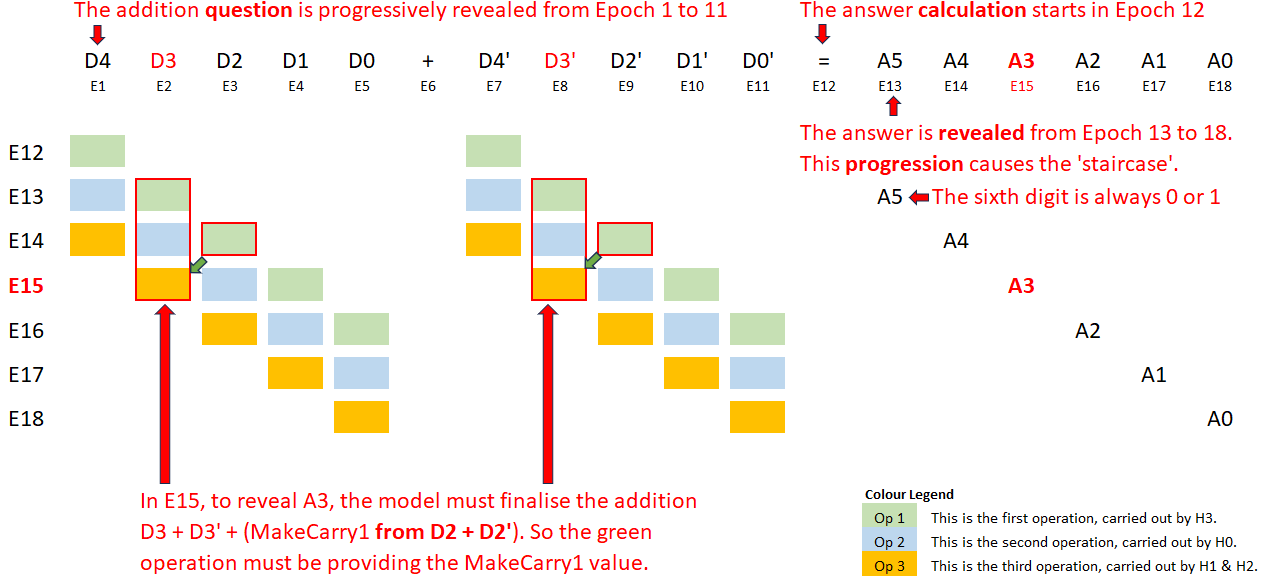

### Show attention patterns for some randomly chosen tokens

In [33]:
def show_token_attention_patterns(index, token_at_index):
  attention_pattern=cache["pattern", 0, "attn"][index]

  # First token attention patterns
  token_strs = [str(token) for token in token_at_index.tolist()]
  display(cv.attention.attention_patterns(
      tokens=token_strs,
      attention=attention_pattern,
      attention_head_names=[f"L0H{i}" for i in range(4)],
  ))
  print(tokens_to_string(token_strs))


sample_size = 3

# Show attention patterns for some randomly chosen tokens
for i in range(sample_size):
  show_token_attention_patterns(i, tokens[i])

  71760 + 25032 = 096792


  10396 + 51776 = 062172


  62686 + 81927 = 144613


### Insights:

In mathematical addition every digit in the question is independent. No token impacts the likelihood of the next token. So the Murk is unpredictable. We assume the algorithm does not use the murk and so the residual stream is random at the end of the murk.

The attention only shows patterns after the full "question" has been revealed (post murk, in layer ~12). All Heads show a strong coherence, with a strong “staircase” pattern:
* They mainly attend to pairs of digits that need to be combined. This is expected and aligns with the BaseAdd etc task definitions.
* The staircase means the head attends to each pair of digits, from left (ten thousands digit) to right (units digit), in success layers (time slices). While a suboptimal ordering for human manual addition methods, this is the “order as written”.

Importantly, when viewing all heads in the (leftmost) image, the staircase is ~3 blocks wide. This means the head's staircases are offset horizontally from each other. Specifically:
* The H3 staircase is the right-most, meaning it is the first to attend to pair of tokens.
* The H0 staircase is in the middle.
* The H1 and H2 staircases overlap and are left-most, so they attend to pairs of digits last.



### Show attention patterns for some tokens which BaseAdd only



In [34]:
any_use_carry1s = torch.any(use_carry1s.bool(), dim=1)
no_use_carry1s = ~ any_use_carry1s
num_cases = utils.to_numpy(torch.sum(no_use_carry1s))
if num_cases >= sample_size :
  print(f"Attention patterns for first few BaseAdd-only tokens ({num_cases} of {tokens.shape[0]})")
  baseadd_tokens = tokens[no_use_carry1s==1]
  for i in range(sample_size):
    show_token_attention_patterns(i, baseadd_tokens[i])

Attention patterns for first few BaseAdd-only tokens (9 of 64)


  71760 + 25032 = 096792


  30316 + 09411 = 039727


  41111 + 97771 = 138882


Show attention patterns for some tokens which UseCarry1 (and not UseSum9)

In [35]:
num_use_carry1s = torch.sum(use_carry1s, dim=1)
any_use_carry1s = torch.where( num_use_carry1s != 0, 1, 0 ) # At least one digit uses UseCarry1
num_sum9s = torch.sum(use_sum9s, dim=1)
no_sum9s = torch.where( num_sum9s == 0, 1, 0 ) # No digits have Sum9 true
filtered_cases = any_use_carry1s & no_sum9s
num_cases = utils.to_numpy(torch.sum(filtered_cases))
if num_cases >= sample_size :
  print(f"Attention patterns for first few UseCarry1-only (and not UseSum9) tokens ({num_cases} of {tokens.shape[0]})")
  usecarry1_tokens = tokens[filtered_cases==1]
  for i in range(sample_size):
    show_token_attention_patterns(i, usecarry1_tokens[i])

Attention patterns for first few UseCarry1-only (and not UseSum9) tokens (48 of 64)


  10396 + 51776 = 062172


  62686 + 81927 = 144613


  51698 + 42674 = 094372


Show attention patterns for some tokens which UseSum9

In [36]:
num_sum9s = torch.sum(use_sum9s, dim=1)
any_sum9s = torch.where( num_sum9s != 0, 1, 0 ) # At least one digit uses Sum9
num_cases = utils.to_numpy(torch.sum(any_sum9s))
if num_cases >= sample_size :
  print(f"Attention patterns for first few UseSum9 tokens ({num_cases} of {tokens.shape[0]})")
  usesum9_tokens = tokens[any_sum9s==1]
  for i in range(sample_size):
    show_token_attention_patterns(i, usesum9_tokens[i])

Attention patterns for first few UseSum9 tokens (7 of 64)


  83735 + 26298 = 110033


  67389 + 02319 = 069708


  13145 + 28956 = 042101


# White-box Analysis - Looking at Activations

No insights gained from this section so far.

In [37]:
#Org px.imshow(cache["pattern", 0].mean(dim=0)[:, -1, :], title="Average Attention Pattern per Head", xaxis="Source", yaxis="Head", x=['a', 'b', '='])
px.imshow(cache["pattern", 0].mean(dim=0)[:, -1, :].cpu(), title="Average Attention Pattern per Head", labels={"x":"Source", "y":"Head"})


In [38]:
p = 8
#Org px.imshow(cache["pattern", 0][:, 0, -1, 0].reshape(p, p), title="Attention for Head 0 from a -> =", xaxis="b", yaxis="a")
px.imshow(cache["pattern", 0][:, 0, -1, 0].reshape(p, p).cpu(), title="Attention for Head 0 from a -> =", labels={"x":"b", "y":"a"})


In [39]:
# Org px.imshow(
#    einops.rearrange(cache["pattern", 0][:, :, -1, 0], "(a b) head -> head a b", a=p, b=p),
#    title="Attention for Head 0 from a -> =", xaxis="b", yaxis="a", facet_col=0)

px.imshow(
   einops.rearrange(cache["pattern", 0][:, :, -1, 0].cpu(), "(a b) head -> head a b", a=p, b=p),
   title="Attention for Head 0 from a -> =", labels={"x":"b", "y":"a"}, facet_col=0)

Plotting neuron activations

In [40]:
cache["post", 0, "mlp"].shape

torch.Size([64, 18, 2048])

In [41]:
# Org px.imshow(
#     einops.rearrange(neuron_acts[:, :5], "(a b) neuron -> neuron a b", a=p, b=p),
#     title="First 5 neuron acts", xaxis="b", yaxis="a", facet_col=0)

px.imshow(
  einops.rearrange(neuron_acts[:, :5].cpu(), "(a b) neuron -> neuron a b", a=p, b=p),
  title="First 5 neuron acts", labels={"x":"b", "y":"a"}, facet_col=0)

Singular Value Decomposition

In [42]:
U, S, Vh = torch.svd(W_E)
line(S, title="Singular Values")
imshow(U, title="Principal Components on the Input")

In [43]:
U, S, Vh = torch.svd(W_E)
line(S, title="Singular Values")
imshow(U, title="Principal Components on the Input")

In [44]:
# Control - random Gaussian matrix
U, S, Vh = torch.svd(torch.randn_like(W_E))
line(S, title="Singular Values Random")
imshow(U, title="Principal Components Random")

In [45]:
U, S, Vh = torch.svd(W_E)
line(U[:, :8].T, title="Principal Components of the embedding", xaxis="Input Vocabulary")

# Ablate one head at a time
See if one particular head as a strong impact on loss associated with BaseAdd, UseCarry1 or useSum9.

Overall, effect of ablating head on loss:
- H3 makes things 0.50 higher (worse)
- H0 makes things 0.25 higher (worse)
- H1 makes things 0.15 lower (better)
- H2 makes things 0.4 lower (better)

In detail, effect of ablating head on loss:
- H3 makes BaseAdd 1.0 higher, UseCarry1 0.5 higher, UseSum9 1.0 higher
- H0 makes BaseAdd 0.2 lower, UseCarry1 0.35 higher, UseSum9 0.3 higher
- H1 makes BaseAdd 0.44 lower, UseCarry1 0.16 lower, UseSum9 2.5 higher
- H2 makes BaseAdd 0.43 lower, UseCarry1 0.42 lower, UseSum9 0.3 lower

Where change of 1.0 is 20%, so 0.5 is 10%

In [46]:
layer_to_ablate = 0
head_index_to_ablate = 2

# Define a head ablation hook
def head_ablation_hook(
    value: Float[torch.Tensor, "batch pos head_index d_head"],
    hook: HookPoint
) -> Float[torch.Tensor, "batch pos head_index d_head"]:
    #print(f"Shape of the value tensor: {value.shape}")
    value[:, :, head_index_to_ablate, :] = 0.
    return value

print("token.size", tokens.shape)
print("baseadd_tokens.size", baseadd_tokens.shape)
print("usecarry1_tokens.size", usecarry1_tokens.shape)
print("usesum9_tokens.size", usesum9_tokens.shape)

original_loss = model(tokens, return_type="loss")
print(f"Original Loss: {original_loss.item():.3f}")

fwd_hooks=[(
    utils.get_act_name("v", layer_to_ablate),
    head_ablation_hook
    )]

for head_index_to_ablate in range(4):

  ablated_loss = model.run_with_hooks(
      tokens,
      return_type="loss",
      fwd_hooks=fwd_hooks)
  all_tokens_ablated_loss = ablated_loss.item()

  ablated_loss = model.run_with_hooks(
      baseadd_tokens,
      return_type="loss",
      fwd_hooks=fwd_hooks)
  baseadd_tokens_ablated_loss = ablated_loss.item()

  ablated_loss = model.run_with_hooks(
      usecarry1_tokens,
      return_type="loss",
      fwd_hooks=fwd_hooks)
  usecarry1_tokens_ablated_loss = ablated_loss.item()

  ablated_loss = model.run_with_hooks(
      usesum9_tokens,
      return_type="loss",
      fwd_hooks=fwd_hooks)
  usesum9_tokens_ablated_loss = ablated_loss.item()

  print(f"Ablated Loss for head {head_index_to_ablate}: All={all_tokens_ablated_loss:.3f} BaseAdd={baseadd_tokens_ablated_loss:.3f} UseCarry1={usecarry1_tokens_ablated_loss:.3f} UseSum9={usesum9_tokens_ablated_loss:.3f}")



token.size torch.Size([64, 18])
baseadd_tokens.size torch.Size([9, 18])
usecarry1_tokens.size torch.Size([48, 18])
usesum9_tokens.size torch.Size([7, 18])
Original Loss: 4.760
Ablated Loss for head 0: All=5.202 BaseAdd=4.930 UseCarry1=5.270 UseSum9=5.088
Ablated Loss for head 1: All=4.196 BaseAdd=3.956 UseCarry1=4.217 UseSum9=4.356
Ablated Loss for head 2: All=4.006 BaseAdd=3.951 UseCarry1=4.010 UseSum9=4.047
Ablated Loss for head 3: All=5.470 BaseAdd=6.008 UseCarry1=5.357 UseSum9=5.554


# Corrupted Query

In [47]:
clean_prompt = "77426+17611="; # = 77426 + 17611 = 095037
corrupted_prompt = "77426+17613=";  # = 77426 + 17613 = 095039

#clean_tokens = model.to_tokens(clean_prompt)
#corrupted_tokens = model.to_tokens(corrupted_prompt)
clean_tokens = string_to_tokens(clean_prompt)
corrupted_tokens = string_to_tokens(corrupted_prompt)

def logits_to_logit_diff(logits, correct_answer="095037", incorrect_answer="095039"):
    # model.to_single_token maps a string value of a single token to the token index for that token
    # If the string is not a single token, it raises an error.
    correct_index = model.to_single_token(correct_answer)
    incorrect_index = model.to_single_token(incorrect_answer)
    return logits[0, -1, correct_index] - logits[0, -1, incorrect_index]

# We run on the clean prompt with the cache so we store activations to patch in later.
clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logit_diff = logits_to_logit_diff(clean_logits)
print(f"Clean logit difference: {clean_logit_diff.item():.3f}")

# We don't need to cache on the corrupted prompt.
corrupted_logits = model(corrupted_tokens)
corrupted_logit_diff = logits_to_logit_diff(corrupted_logits)
print(f"Corrupted logit difference: {corrupted_logit_diff.item():.3f}")

AssertionError: ignored

## Residual Head Patching

In [ ]:
# We define a residual stream patching hook
# We choose to act on the residual stream at the start of the layer, so we call it resid_pre
def residual_stream_patching_hook(
    resid_pre: Float[torch.Tensor, "batch pos d_model"],
    hook: HookPoint,
    position: int
) -> Float[torch.Tensor, "batch pos d_model"]:
    # Each HookPoint has a name attribute giving the name of the hook.
    clean_resid_pre = clean_cache[hook.name]
    resid_pre[:, position, :] = clean_resid_pre[:, position, :]
    return resid_pre

# We make a tensor to store the results for each patching run. We put it on the model's device to avoid needing to move things between the GPU and CPU, which can be slow.
num_positions = len(clean_tokens[0])
ioi_patching_result = torch.zeros((model.cfg.n_layers, num_positions), device=model.cfg.device)

for layer in tqdm.tqdm(range(model.cfg.n_layers)):
    for position in range(num_positions):
        # Use functools.partial to create a temporary hook function with the position fixed
        temp_hook_fn = partial(residual_stream_patching_hook, position=position)
        # Run the model with the patching hook
        patched_logits = model.run_with_hooks(corrupted_tokens, fwd_hooks=[
            (utils.get_act_name("resid_pre", layer), temp_hook_fn)
        ])
        # Calculate the logit difference
        patched_logit_diff = logits_to_logit_diff(patched_logits).detach()
        # Store the result, normalizing by the clean and corrupted logit difference so it's between 0 and 1 (ish)
        ioi_patching_result[layer, position] = (patched_logit_diff - corrupted_logit_diff)/(clean_logit_diff - corrupted_logit_diff)

In [ ]:
# To add a hook that modifies rather than caches you do something like this
def test_hook(value, name):
  # Zero ablate the layer 0 attention
  #value = torch.zeros_like(value)
  return value

#hook_attn_0 = model.blocks[0].attn.hook_attn
hook_attn_0 = model.blocks[0].attn.hook

cache = {}
model.cache_all(cache)

hook_attn_0.remove_hooks()
logits_without_hook = model(tokens)
hook_attn_0.add_hook(test_hook)
logits_with_hook = model(tokens)
hook_attn_0.remove_hooks()

#assert not torch.equal(logits_without_hook, logits_with_hook)

print("logits_without_hook.shape", logits_without_hook.shape)
predicted_tokens = torch.argmax(logits_without_hook, dim=-1)
print(predicted_tokens.shape)
print(predicted_tokens[0])
print(tokens_to_string(predicted_tokens[0]))
#print("tokens_to_string", tokens_to_string(logits_without_hook[:,1]))
#print("logits_without_hook", logits_without_hook)
#print("logits_with_hook.shape", logits_with_hook.shape)
#print("logits_with_hook", logits_with_hook)

## Logit Lens
From https://colab.research.google.com/github/neelnanda-io/TransformerLens/blob/main/demos/Exploratory_Analysis_Demo.ipynb
"Fascinatingly, we see that the model is utterly unable to do the task until layer 7, almost all performance comes from attention layer 9, and performance actually decreases from there."

Layer k of a transformer means the kth transformer block, but each block consists of an attention layer (to move information around) and an MLP layer (to process information).

In [ ]:
accumulated_residual, labels = cache.accumulated_resid(layer=-1, incl_mid=True, pos_slice=-1, return_labels=True)
logit_lens_logit_diffs = residual_stack_to_logit_diff(accumulated_residual, cache)
line(logit_lens_logit_diffs, x=np.arange(model.cfg.n_layers*2+1)/2, hover_name=labels, title="Logit Difference From Accumulate Residual Stream")

## Head Attribution
From https://colab.research.google.com/github/neelnanda-io/TransformerLens/blob/main/demos/Exploratory_Analysis_Demo.ipynb
We can further break down the output of each attention layer into the sum of the outputs of each attention head.

"Each attention layer consists of 12 heads, which each act independently and additively. We see that only a few heads really matter - heads L9H6 and L9H9 contribute a lot positively (explaining why attention layer 9 is so important), while heads L10H7 and L11H10 contribute a lot negatively (explaining why attention layer 10 and layer 11 are actively harmful).

In [ ]:
per_head_residual, labels = cache.stack_head_results(layer=-1, pos_slice=-1, return_labels=True)
per_head_logit_diffs = residual_stack_to_logit_diff(per_head_residual, cache)
per_head_logit_diffs = einops.rearrange(per_head_logit_diffs, "(layer head_index) -> layer head_index", layer=model.cfg.n_layers, head_index=model.cfg.n_heads)
imshow(per_head_logit_diffs, labels={"x":"Head", "y":"Layer"}, title="Logit Difference From Each Head")